In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [2]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [3]:
# Import libraries for tensors
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# For fbeta-score
from torchmetrics.functional import fbeta_score

In [5]:
# For model construction
from collections import OrderedDict

In [6]:
# Import tqdm for progress bar construction
import tqdm

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [8]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)

# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [9]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [10]:
# Modify dataframe for K-Fold Cross Validation (birdclef2021)
birdclef_csv = pandas.read_csv(AudioImage_Path + 'metadata.csv')
birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
    AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
    birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

birdclef_csv = birdclef_csv.dropna()
birdclef_csv = birdclef_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
birdclef_dataframe = birdclef_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
    birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [11]:
# Class for ff1010 dataset
class birdclef(Dataset):
    def __init__(self, dataframe, process='train', labels='label_id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        if len(source.shape) == 3:
            source = np.expand_dims(source, axis=2)
        source = source.transpose(2, 0, 1, 3)
        N, H, W, C = source.shape
        
        # Apply transform
        if self.process == 'train':
            source = torch.stack([self.train_transform(Image.fromarray(x)) for x in source])
        elif self.process == 'valid':
            source = torch.stack([self.val_transform(Image.fromarray(x)) for x in source])
        
        # Select the middle input from slices
        source = source[N // 2]

        return source, torch.tensor(self.labels[idx], dtype=ltype)
    
    def __len__(self):
        return len(self.dataframe)

This function evaluates model.

In [12]:
def evaluate_model(loader, model, beta=1.0):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)
            scores = model(torch.squeeze(x, 0))
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.cross_entropy(scores, y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)
            
            # Erase memory caches
            del x, y, scores, log_loss
        
        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

Let's train with model 2.

In [13]:
import os

# Print period for accuracy.
print_period = 100

# Hyper-parameters for training 
birdclef_batch = 32
birdclef_epoch = 50

# Learning Rate.
learning_rate_2 = 0.0008

# L2 Regularization Hyperparamter
weight_decay_2 = 0.01

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 2.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 397.
class Model2(nn.Module):
    def __init__(self, num_classes=397):
        super().__init__()
        self.resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
        self.relu = nn.ReLU().to(device)
        self.linear = nn.Linear(1000, num_classes, bias=True).to(device)
    
    def forward (self, x):
        x = self.resnet50(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

cur_model = Model2()
print(cur_model)

def checkpoint(model, optimizer, scheduler, train_losses, val_losses, log_scores, fbeta_scores, epoch):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'log_scores': log_scores,
            'fbeta_scores': fbeta_scores,
            }, './bird_specificator.pt')

def train_model(model, train_loader, val_loader, optimizer, scheduler, beta=beta, epoch=birdclef_epoch, ckpt_enable=True):
    val_losses = []
    train_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    saved_epoch = -1
    
    # Load checkpoint
    if ckpt_enable and os.path.exists('./bird_specificator.pt'):
        ckpt = torch.load('./bird_specificator.pt')
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        train_losses = ckpt['train_losses']
        val_losses = ckpt['val_losses']
        log_scores = ckpt['log_scores']
        fbeta_scores = ckpt['fbeta_scores']
        saved_epoch = ckpt['epoch']
    
    for e in range(epoch):
        if e <= saved_epoch:
            continue
            
        epoch_losses = []
        print(f"Training model 2, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):          
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)

            scores = model(torch.squeeze(x, 0))
            loss = F.cross_entropy(scores, y) # Log loss for our project.

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            # every print_period, print loss.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
                
            # Erase memory caches
            del source, label, x, y, scores, loss
            
        # Cosine LR Annealing Scheduler
        scheduler.step()
        
        # Append the score to lists
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)
        
        # every epoch, save the model
        checkpoint(model, optimizer, scheduler, train_losses, val_losses, log_scores, fbeta_scores, e)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Model2(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [14]:
# Train loop for bird specificator
def bird_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = birdclef(train_dataframe, process='train', labels='label_id')
    val_data = birdclef(val_dataframe, process='valid', labels='label_id')
    test_data = birdclef(test_dataframe, process='valid', labels='label_id')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=birdclef_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate_2, weight_decay=weight_decay_2)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=birdclef_epoch, eta_min=1e-5)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, scheduler, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [15]:
# Train, Validate and Test for nocall detector
def bird(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = bird_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [16]:
val_losses, train_losses, log_scores, fbeta_scores, test_scores = \
    bird(cur_model, birdclef_dataframe, 1, 0)
del cur_model

# for i in range(2, 5):
#     cur_model = Model2()
#     cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, birdclef_dataframe, i, 0)
#     val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
#     train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
#     log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
#     fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
#     for j in range(len(test_scores)):
#         test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Test set : 0, Validation set : 1
Training model 2, epoch 1


  0%|                                                                               | 1/1178 [00:03<1:12:49,  3.71s/it]

Iteration 0, loss = 6.0913


  9%|██████▊                                                                        | 101/1178 [00:45<07:17,  2.46it/s]

Iteration 100, loss = 5.9085


 17%|█████████████▍                                                                 | 201/1178 [01:27<06:42,  2.43it/s]

Iteration 200, loss = 5.9377


 26%|████████████████████▏                                                          | 301/1178 [02:10<06:01,  2.43it/s]

Iteration 300, loss = 5.8638


 34%|██████████████████████████▉                                                    | 401/1178 [02:52<05:49,  2.23it/s]

Iteration 400, loss = 5.9424


 43%|█████████████████████████████████▌                                             | 501/1178 [03:35<05:02,  2.24it/s]

Iteration 500, loss = 5.9190


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:17<04:08,  2.33it/s]

Iteration 600, loss = 5.8749


 60%|███████████████████████████████████████████████                                | 701/1178 [05:00<03:35,  2.21it/s]

Iteration 700, loss = 5.6773


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:44<02:43,  2.30it/s]

Iteration 800, loss = 5.2457


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:26<01:59,  2.31it/s]

Iteration 900, loss = 5.7427


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:09<01:15,  2.35it/s]

Iteration 1000, loss = 5.8042


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:52<00:33,  2.32it/s]

Iteration 1100, loss = 5.4441


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:25<00:00,  2.33it/s]


Checking accuracy score on validation set.

Accuracy: 255 / 12575 correct (2.03)
Log Loss score:	5.59
Fbeta-score (beta=1): 	0.02
Training model 2, epoch 2


  0%|                                                                                 | 1/1178 [00:00<08:51,  2.21it/s]

Iteration 0, loss = 5.6683


  9%|██████▊                                                                        | 101/1178 [00:43<07:30,  2.39it/s]

Iteration 100, loss = 5.3970


 17%|█████████████▍                                                                 | 201/1178 [01:25<06:53,  2.36it/s]

Iteration 200, loss = 5.8115


 26%|████████████████████▏                                                          | 301/1178 [02:07<05:50,  2.50it/s]

Iteration 300, loss = 5.9460


 34%|██████████████████████████▉                                                    | 401/1178 [02:50<05:09,  2.51it/s]

Iteration 400, loss = 5.3812


 43%|█████████████████████████████████▌                                             | 501/1178 [03:32<04:41,  2.40it/s]

Iteration 500, loss = 5.6859


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:15<03:56,  2.44it/s]

Iteration 600, loss = 5.2242


 60%|███████████████████████████████████████████████                                | 701/1178 [04:57<03:19,  2.39it/s]

Iteration 700, loss = 5.4067


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:40<02:40,  2.34it/s]

Iteration 800, loss = 5.5942


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:24<01:48,  2.56it/s]

Iteration 900, loss = 5.4226


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:06<01:17,  2.27it/s]

Iteration 1000, loss = 5.4147


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:51<00:31,  2.42it/s]

Iteration 1100, loss = 5.2999


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:26<00:00,  2.33it/s]


Checking accuracy score on validation set.

Accuracy: 573 / 12575 correct (4.56)
Log Loss score:	5.20
Fbeta-score (beta=1): 	0.05
Training model 2, epoch 3


  0%|                                                                                 | 1/1178 [00:00<08:41,  2.26it/s]

Iteration 0, loss = 5.1533


  9%|██████▊                                                                        | 101/1178 [00:43<07:33,  2.37it/s]

Iteration 100, loss = 4.7560


 17%|█████████████▍                                                                 | 201/1178 [01:28<07:06,  2.29it/s]

Iteration 200, loss = 5.1378


 26%|████████████████████▏                                                          | 301/1178 [02:10<06:02,  2.42it/s]

Iteration 300, loss = 4.9748


 34%|██████████████████████████▉                                                    | 401/1178 [02:53<05:13,  2.48it/s]

Iteration 400, loss = 4.4888


 43%|█████████████████████████████████▌                                             | 501/1178 [03:36<04:43,  2.39it/s]

Iteration 500, loss = 4.5175


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:19<04:07,  2.33it/s]

Iteration 600, loss = 4.9460


 60%|███████████████████████████████████████████████                                | 701/1178 [05:03<03:18,  2.40it/s]

Iteration 700, loss = 4.6180


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:46<02:43,  2.30it/s]

Iteration 800, loss = 4.8248


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:31<02:11,  2.10it/s]

Iteration 900, loss = 4.4721


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:16<01:15,  2.33it/s]

Iteration 1000, loss = 4.7250


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [08:03<00:33,  2.33it/s]

Iteration 1100, loss = 4.8155


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:37<00:00,  2.28it/s]


Checking accuracy score on validation set.

Accuracy: 1283 / 12575 correct (10.20)
Log Loss score:	4.63
Fbeta-score (beta=1): 	0.10
Training model 2, epoch 4


  0%|                                                                                 | 1/1178 [00:00<11:04,  1.77it/s]

Iteration 0, loss = 4.7292


  9%|██████▊                                                                        | 101/1178 [00:44<08:25,  2.13it/s]

Iteration 100, loss = 4.4197


 17%|█████████████▍                                                                 | 201/1178 [01:27<06:48,  2.39it/s]

Iteration 200, loss = 4.4032


 26%|████████████████████▏                                                          | 301/1178 [02:11<06:19,  2.31it/s]

Iteration 300, loss = 4.4897


 34%|██████████████████████████▉                                                    | 401/1178 [02:53<06:06,  2.12it/s]

Iteration 400, loss = 4.9543


 43%|█████████████████████████████████▌                                             | 501/1178 [03:34<04:19,  2.61it/s]

Iteration 500, loss = 4.7307


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:15<03:54,  2.46it/s]

Iteration 600, loss = 4.6724


 60%|███████████████████████████████████████████████                                | 701/1178 [04:56<03:10,  2.50it/s]

Iteration 700, loss = 4.5027


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:38<02:41,  2.33it/s]

Iteration 800, loss = 4.3350


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:20<01:44,  2.64it/s]

Iteration 900, loss = 4.0636


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:01<01:11,  2.46it/s]

Iteration 1000, loss = 4.5788


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:42<00:31,  2.41it/s]

Iteration 1100, loss = 4.3417


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:14<00:00,  2.38it/s]


Checking accuracy score on validation set.

Accuracy: 1568 / 12575 correct (12.47)
Log Loss score:	4.44
Fbeta-score (beta=1): 	0.12
Training model 2, epoch 5


  0%|                                                                                 | 1/1178 [00:00<09:08,  2.15it/s]

Iteration 0, loss = 4.2785


  9%|██████▊                                                                        | 101/1178 [00:43<08:01,  2.24it/s]

Iteration 100, loss = 4.7910


 17%|█████████████▍                                                                 | 201/1178 [01:28<07:20,  2.22it/s]

Iteration 200, loss = 3.9748


 26%|████████████████████▏                                                          | 301/1178 [02:09<06:30,  2.24it/s]

Iteration 300, loss = 4.2922


 34%|██████████████████████████▉                                                    | 401/1178 [02:49<05:24,  2.40it/s]

Iteration 400, loss = 4.7136


 43%|█████████████████████████████████▌                                             | 501/1178 [03:31<04:53,  2.31it/s]

Iteration 500, loss = 4.2633


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:12<04:12,  2.28it/s]

Iteration 600, loss = 3.9719


 60%|███████████████████████████████████████████████                                | 701/1178 [04:54<03:09,  2.51it/s]

Iteration 700, loss = 4.7190


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:38<03:01,  2.08it/s]

Iteration 800, loss = 3.8008


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:23<02:12,  2.10it/s]

Iteration 900, loss = 4.2048


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:06<01:18,  2.25it/s]

Iteration 1000, loss = 4.2936


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:51<00:35,  2.17it/s]

Iteration 1100, loss = 3.7268


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:25<00:00,  2.33it/s]


Checking accuracy score on validation set.

Accuracy: 2174 / 12575 correct (17.29)
Log Loss score:	4.15
Fbeta-score (beta=1): 	0.17
Training model 2, epoch 6


  0%|                                                                                 | 1/1178 [00:00<09:54,  1.98it/s]

Iteration 0, loss = 3.5470


  9%|██████▊                                                                        | 101/1178 [00:48<09:22,  1.92it/s]

Iteration 100, loss = 4.1470


 17%|█████████████▍                                                                 | 201/1178 [01:35<07:20,  2.22it/s]

Iteration 200, loss = 4.1557


 26%|████████████████████▏                                                          | 301/1178 [02:20<07:02,  2.08it/s]

Iteration 300, loss = 4.0718


 34%|██████████████████████████▉                                                    | 401/1178 [03:10<06:05,  2.12it/s]

Iteration 400, loss = 4.5493


 43%|█████████████████████████████████▌                                             | 501/1178 [03:56<04:33,  2.48it/s]

Iteration 500, loss = 3.9387


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:40<04:14,  2.27it/s]

Iteration 600, loss = 3.6813


 60%|███████████████████████████████████████████████                                | 701/1178 [05:27<03:30,  2.27it/s]

Iteration 700, loss = 3.8072


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:12<02:47,  2.25it/s]

Iteration 800, loss = 4.3230


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:58<02:03,  2.24it/s]

Iteration 900, loss = 4.3888


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [07:43<01:23,  2.13it/s]

Iteration 1000, loss = 3.9688


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [08:30<00:32,  2.39it/s]

Iteration 1100, loss = 3.5498


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [09:06<00:00,  2.16it/s]


Checking accuracy score on validation set.

Accuracy: 2523 / 12575 correct (20.06)
Log Loss score:	3.97
Fbeta-score (beta=1): 	0.20
Training model 2, epoch 7


  0%|                                                                                 | 1/1178 [00:00<08:37,  2.27it/s]

Iteration 0, loss = 4.0168


  9%|██████▊                                                                        | 101/1178 [00:40<06:56,  2.59it/s]

Iteration 100, loss = 3.8328


 17%|█████████████▍                                                                 | 201/1178 [01:20<06:16,  2.60it/s]

Iteration 200, loss = 3.8836


 26%|████████████████████▏                                                          | 301/1178 [02:01<05:44,  2.55it/s]

Iteration 300, loss = 3.1926


 34%|██████████████████████████▉                                                    | 401/1178 [02:41<05:24,  2.39it/s]

Iteration 400, loss = 3.8022


 43%|█████████████████████████████████▌                                             | 501/1178 [03:22<04:47,  2.35it/s]

Iteration 500, loss = 3.5014


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:03<04:05,  2.35it/s]

Iteration 600, loss = 3.4566


 60%|███████████████████████████████████████████████                                | 701/1178 [04:44<03:17,  2.41it/s]

Iteration 700, loss = 3.6354


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:24<02:39,  2.37it/s]

Iteration 800, loss = 4.0104


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:04<01:42,  2.70it/s]

Iteration 900, loss = 3.9572


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:44<01:08,  2.57it/s]

Iteration 1000, loss = 3.7322


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:25<00:33,  2.31it/s]

Iteration 1100, loss = 3.9548


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [07:57<00:00,  2.47it/s]


Checking accuracy score on validation set.

Accuracy: 2938 / 12575 correct (23.36)
Log Loss score:	3.82
Fbeta-score (beta=1): 	0.23
Training model 2, epoch 8


  0%|                                                                                 | 1/1178 [00:00<07:31,  2.60it/s]

Iteration 0, loss = 3.2869


  9%|██████▊                                                                        | 101/1178 [00:41<09:03,  1.98it/s]

Iteration 100, loss = 4.2562


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:37,  2.46it/s]

Iteration 200, loss = 3.4198


 26%|████████████████████▏                                                          | 301/1178 [02:02<06:06,  2.39it/s]

Iteration 300, loss = 3.0667


 34%|██████████████████████████▉                                                    | 401/1178 [02:44<06:05,  2.13it/s]

Iteration 400, loss = 3.0389


 43%|█████████████████████████████████▌                                             | 501/1178 [03:28<04:52,  2.32it/s]

Iteration 500, loss = 3.5391


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:09<03:45,  2.55it/s]

Iteration 600, loss = 3.7247


 60%|███████████████████████████████████████████████                                | 701/1178 [04:49<03:02,  2.61it/s]

Iteration 700, loss = 3.4340


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:31<02:38,  2.38it/s]

Iteration 800, loss = 3.7038


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:11<01:50,  2.51it/s]

Iteration 900, loss = 3.7895


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:51<01:06,  2.68it/s]

Iteration 1000, loss = 3.1234


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:32<00:32,  2.33it/s]

Iteration 1100, loss = 3.8328


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:03<00:00,  2.44it/s]


Checking accuracy score on validation set.

Accuracy: 2930 / 12575 correct (23.30)
Log Loss score:	3.80
Fbeta-score (beta=1): 	0.23
Training model 2, epoch 9


  0%|                                                                                 | 1/1178 [00:00<10:17,  1.90it/s]

Iteration 0, loss = 3.3387


  9%|██████▊                                                                        | 101/1178 [00:40<07:24,  2.42it/s]

Iteration 100, loss = 3.1505


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:31,  2.50it/s]

Iteration 200, loss = 4.0336


 26%|████████████████████▏                                                          | 301/1178 [02:02<06:01,  2.42it/s]

Iteration 300, loss = 3.2937


 34%|██████████████████████████▉                                                    | 401/1178 [02:43<05:24,  2.39it/s]

Iteration 400, loss = 3.6318


 43%|█████████████████████████████████▌                                             | 501/1178 [03:23<04:49,  2.34it/s]

Iteration 500, loss = 3.1434


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<03:57,  2.43it/s]

Iteration 600, loss = 3.3535


 60%|███████████████████████████████████████████████                                | 701/1178 [04:46<03:15,  2.44it/s]

Iteration 700, loss = 3.7908


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:25<02:17,  2.75it/s]

Iteration 800, loss = 3.3134


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:05<01:51,  2.49it/s]

Iteration 900, loss = 3.7698


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:46<01:12,  2.45it/s]

Iteration 1000, loss = 3.4061


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:28<00:30,  2.53it/s]

Iteration 1100, loss = 3.1822


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [07:59<00:00,  2.46it/s]


Checking accuracy score on validation set.

Accuracy: 3359 / 12575 correct (26.71)
Log Loss score:	3.60
Fbeta-score (beta=1): 	0.27
Training model 2, epoch 10


  0%|                                                                                 | 1/1178 [00:00<10:54,  1.80it/s]

Iteration 0, loss = 3.1194


  9%|██████▊                                                                        | 101/1178 [00:42<07:39,  2.34it/s]

Iteration 100, loss = 3.6151


 17%|█████████████▍                                                                 | 201/1178 [01:23<06:45,  2.41it/s]

Iteration 200, loss = 3.1046


 26%|████████████████████▏                                                          | 301/1178 [02:04<06:14,  2.34it/s]

Iteration 300, loss = 3.5671


 34%|██████████████████████████▉                                                    | 401/1178 [02:44<05:22,  2.41it/s]

Iteration 400, loss = 3.3968


 43%|█████████████████████████████████▌                                             | 501/1178 [03:24<04:38,  2.43it/s]

Iteration 500, loss = 3.9222


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:05<03:29,  2.75it/s]

Iteration 600, loss = 3.8376


 60%|███████████████████████████████████████████████                                | 701/1178 [04:46<03:10,  2.50it/s]

Iteration 700, loss = 3.9018


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:27<02:28,  2.55it/s]

Iteration 800, loss = 3.3824


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:07<01:45,  2.62it/s]

Iteration 900, loss = 3.4548


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:48<01:07,  2.64it/s]

Iteration 1000, loss = 3.6841


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:29<00:34,  2.24it/s]

Iteration 1100, loss = 3.6058


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:00<00:00,  2.45it/s]


Checking accuracy score on validation set.

Accuracy: 3511 / 12575 correct (27.92)
Log Loss score:	3.63
Fbeta-score (beta=1): 	0.28
Training model 2, epoch 11


  0%|                                                                                 | 1/1178 [00:00<09:09,  2.14it/s]

Iteration 0, loss = 3.3381


  9%|██████▊                                                                        | 101/1178 [00:41<07:21,  2.44it/s]

Iteration 100, loss = 3.7669


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:42,  2.43it/s]

Iteration 200, loss = 3.0328


 26%|████████████████████▏                                                          | 301/1178 [02:03<05:50,  2.50it/s]

Iteration 300, loss = 3.1214


 34%|██████████████████████████▉                                                    | 401/1178 [02:43<05:09,  2.51it/s]

Iteration 400, loss = 3.1984


 43%|█████████████████████████████████▌                                             | 501/1178 [03:24<04:54,  2.30it/s]

Iteration 500, loss = 2.8682


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:05<04:01,  2.39it/s]

Iteration 600, loss = 3.4057


 60%|███████████████████████████████████████████████                                | 701/1178 [04:46<03:09,  2.51it/s]

Iteration 700, loss = 3.6700


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:26<02:40,  2.35it/s]

Iteration 800, loss = 3.8351


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:08<02:01,  2.28it/s]

Iteration 900, loss = 3.2357


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:47<01:06,  2.64it/s]

Iteration 1000, loss = 3.4758


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:29<00:29,  2.65it/s]

Iteration 1100, loss = 2.9339


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:00<00:00,  2.45it/s]


Checking accuracy score on validation set.

Accuracy: 3777 / 12575 correct (30.04)
Log Loss score:	3.49
Fbeta-score (beta=1): 	0.30
Training model 2, epoch 12


  0%|                                                                                 | 1/1178 [00:00<07:55,  2.48it/s]

Iteration 0, loss = 2.4696


  9%|██████▊                                                                        | 101/1178 [00:41<07:34,  2.37it/s]

Iteration 100, loss = 2.8133


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:55,  2.35it/s]

Iteration 200, loss = 3.1783


 26%|████████████████████▏                                                          | 301/1178 [02:02<05:56,  2.46it/s]

Iteration 300, loss = 3.3699


 34%|██████████████████████████▉                                                    | 401/1178 [02:44<06:03,  2.14it/s]

Iteration 400, loss = 3.2209


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:39,  2.42it/s]

Iteration 500, loss = 3.6166


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<04:06,  2.34it/s]

Iteration 600, loss = 3.7727


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:02,  2.61it/s]

Iteration 700, loss = 2.5733


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:28<02:44,  2.30it/s]

Iteration 800, loss = 3.0324


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:09<01:55,  2.40it/s]

Iteration 900, loss = 2.1905


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:50<01:10,  2.50it/s]

Iteration 1000, loss = 3.3662


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:30<00:29,  2.58it/s]

Iteration 1100, loss = 2.5678


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:02<00:00,  2.44it/s]


Checking accuracy score on validation set.

Accuracy: 3970 / 12575 correct (31.57)
Log Loss score:	3.41
Fbeta-score (beta=1): 	0.32
Training model 2, epoch 13


  0%|                                                                                 | 1/1178 [00:00<10:01,  1.96it/s]

Iteration 0, loss = 3.9255


  9%|██████▊                                                                        | 101/1178 [00:40<07:40,  2.34it/s]

Iteration 100, loss = 2.8141


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:46,  2.40it/s]

Iteration 200, loss = 3.2966


 26%|████████████████████▏                                                          | 301/1178 [02:01<05:49,  2.51it/s]

Iteration 300, loss = 3.0070


 34%|██████████████████████████▉                                                    | 401/1178 [02:42<05:39,  2.29it/s]

Iteration 400, loss = 2.4720


 43%|█████████████████████████████████▌                                             | 501/1178 [03:22<04:22,  2.58it/s]

Iteration 500, loss = 3.0025


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:04<03:51,  2.49it/s]

Iteration 600, loss = 3.0614


 60%|███████████████████████████████████████████████                                | 701/1178 [04:44<03:27,  2.30it/s]

Iteration 700, loss = 2.7505


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:26<02:24,  2.62it/s]

Iteration 800, loss = 2.5758


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:07<01:55,  2.40it/s]

Iteration 900, loss = 2.9587


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:49<01:13,  2.40it/s]

Iteration 1000, loss = 2.7977


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:30<00:29,  2.60it/s]

Iteration 1100, loss = 3.2718


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:02<00:00,  2.44it/s]


Checking accuracy score on validation set.

Accuracy: 4110 / 12575 correct (32.68)
Log Loss score:	3.39
Fbeta-score (beta=1): 	0.33
Training model 2, epoch 14


  0%|                                                                                 | 1/1178 [00:00<08:34,  2.29it/s]

Iteration 0, loss = 2.5520


  9%|██████▊                                                                        | 101/1178 [00:42<07:11,  2.49it/s]

Iteration 100, loss = 3.2185


 17%|█████████████▍                                                                 | 201/1178 [01:23<07:42,  2.11it/s]

Iteration 200, loss = 2.4804


 26%|████████████████████▏                                                          | 301/1178 [02:04<05:43,  2.55it/s]

Iteration 300, loss = 2.9208


 34%|██████████████████████████▉                                                    | 401/1178 [02:46<05:24,  2.39it/s]

Iteration 400, loss = 3.3590


 43%|█████████████████████████████████▌                                             | 501/1178 [03:27<05:31,  2.04it/s]

Iteration 500, loss = 2.5313


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:09<04:05,  2.35it/s]

Iteration 600, loss = 3.1654


 60%|███████████████████████████████████████████████                                | 701/1178 [04:50<03:29,  2.27it/s]

Iteration 700, loss = 2.2197


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:32<02:33,  2.46it/s]

Iteration 800, loss = 3.3937


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:13<01:53,  2.43it/s]

Iteration 900, loss = 3.0953


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:55<01:18,  2.24it/s]

Iteration 1000, loss = 3.2325


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:40<00:32,  2.34it/s]

Iteration 1100, loss = 2.6124


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:12<00:00,  2.39it/s]


Checking accuracy score on validation set.

Accuracy: 4239 / 12575 correct (33.71)
Log Loss score:	3.35
Fbeta-score (beta=1): 	0.34
Training model 2, epoch 15


  0%|                                                                                 | 1/1178 [00:00<10:10,  1.93it/s]

Iteration 0, loss = 3.1222


  9%|██████▊                                                                        | 101/1178 [00:44<08:41,  2.06it/s]

Iteration 100, loss = 2.4371


 17%|█████████████▍                                                                 | 201/1178 [01:30<06:35,  2.47it/s]

Iteration 200, loss = 2.0100


 26%|████████████████████▏                                                          | 301/1178 [02:12<06:20,  2.30it/s]

Iteration 300, loss = 2.6826


 34%|██████████████████████████▉                                                    | 401/1178 [02:53<05:14,  2.47it/s]

Iteration 400, loss = 2.3597


 43%|█████████████████████████████████▌                                             | 501/1178 [03:33<04:38,  2.43it/s]

Iteration 500, loss = 2.5845


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:14<04:46,  2.01it/s]

Iteration 600, loss = 2.9074


 60%|███████████████████████████████████████████████                                | 701/1178 [04:54<03:13,  2.46it/s]

Iteration 700, loss = 2.9074


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:35<02:37,  2.40it/s]

Iteration 800, loss = 2.8924


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:16<01:45,  2.63it/s]

Iteration 900, loss = 3.1853


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:57<01:14,  2.38it/s]

Iteration 1000, loss = 2.4182


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:38<00:32,  2.36it/s]

Iteration 1100, loss = 2.6874


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:09<00:00,  2.41it/s]


Checking accuracy score on validation set.

Accuracy: 4310 / 12575 correct (34.27)
Log Loss score:	3.35
Fbeta-score (beta=1): 	0.34
Training model 2, epoch 16


  0%|                                                                                 | 1/1178 [00:00<07:20,  2.67it/s]

Iteration 0, loss = 2.7385


  9%|██████▊                                                                        | 101/1178 [00:41<07:53,  2.28it/s]

Iteration 100, loss = 2.2518


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:44,  2.42it/s]

Iteration 200, loss = 2.1424


 26%|████████████████████▏                                                          | 301/1178 [02:04<06:14,  2.34it/s]

Iteration 300, loss = 2.2364


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:42,  2.27it/s]

Iteration 400, loss = 2.5838


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:44,  2.38it/s]

Iteration 500, loss = 2.1905


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:05<03:58,  2.42it/s]

Iteration 600, loss = 3.0736


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:32,  2.25it/s]

Iteration 700, loss = 2.4866


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:28<02:39,  2.36it/s]

Iteration 800, loss = 2.7660


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:08<01:52,  2.46it/s]

Iteration 900, loss = 3.3022


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:49<01:20,  2.20it/s]

Iteration 1000, loss = 2.7543


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:30<00:33,  2.27it/s]

Iteration 1100, loss = 2.7970


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:01<00:00,  2.45it/s]


Checking accuracy score on validation set.

Accuracy: 4482 / 12575 correct (35.64)
Log Loss score:	3.23
Fbeta-score (beta=1): 	0.36
Training model 2, epoch 17


  0%|                                                                                 | 1/1178 [00:00<08:57,  2.19it/s]

Iteration 0, loss = 2.1543


  9%|██████▊                                                                        | 101/1178 [00:40<07:34,  2.37it/s]

Iteration 100, loss = 2.4696


 17%|█████████████▍                                                                 | 201/1178 [01:20<06:07,  2.66it/s]

Iteration 200, loss = 2.2077


 26%|████████████████████▏                                                          | 301/1178 [02:00<06:07,  2.39it/s]

Iteration 300, loss = 2.2217


 34%|██████████████████████████▉                                                    | 401/1178 [02:41<05:11,  2.49it/s]

Iteration 400, loss = 2.1007


 43%|█████████████████████████████████▌                                             | 501/1178 [03:23<05:12,  2.17it/s]

Iteration 500, loss = 2.4679


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:03<03:53,  2.47it/s]

Iteration 600, loss = 2.7028


 60%|███████████████████████████████████████████████                                | 701/1178 [04:44<03:15,  2.44it/s]

Iteration 700, loss = 2.8489


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:25<02:39,  2.36it/s]

Iteration 800, loss = 2.5633


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:06<01:48,  2.54it/s]

Iteration 900, loss = 1.7901


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:48<01:07,  2.61it/s]

Iteration 1000, loss = 3.1261


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:29<00:31,  2.44it/s]

Iteration 1100, loss = 2.4278


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:01<00:00,  2.45it/s]


Checking accuracy score on validation set.

Accuracy: 4582 / 12575 correct (36.44)
Log Loss score:	3.26
Fbeta-score (beta=1): 	0.36
Training model 2, epoch 18


  0%|                                                                                 | 1/1178 [00:00<09:06,  2.16it/s]

Iteration 0, loss = 2.5238


  9%|██████▊                                                                        | 101/1178 [00:41<07:18,  2.46it/s]

Iteration 100, loss = 2.4442


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:14,  2.61it/s]

Iteration 200, loss = 1.7999


 26%|████████████████████▏                                                          | 301/1178 [02:03<05:49,  2.51it/s]

Iteration 300, loss = 1.6932


 34%|██████████████████████████▉                                                    | 401/1178 [02:43<05:16,  2.45it/s]

Iteration 400, loss = 2.4605


 43%|█████████████████████████████████▌                                             | 501/1178 [03:24<04:17,  2.63it/s]

Iteration 500, loss = 2.0093


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:05<03:53,  2.47it/s]

Iteration 600, loss = 2.7476


 60%|███████████████████████████████████████████████                                | 701/1178 [04:46<02:59,  2.66it/s]

Iteration 700, loss = 2.9263


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:27<02:29,  2.53it/s]

Iteration 800, loss = 1.9421


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:08<01:53,  2.44it/s]

Iteration 900, loss = 2.1911


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:48<01:04,  2.75it/s]

Iteration 1000, loss = 2.7236


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:30<00:31,  2.45it/s]

Iteration 1100, loss = 2.1694


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:01<00:00,  2.45it/s]


Checking accuracy score on validation set.

Accuracy: 4582 / 12575 correct (36.44)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.36
Training model 2, epoch 19


  0%|                                                                                 | 1/1178 [00:00<09:37,  2.04it/s]

Iteration 0, loss = 2.4078


  9%|██████▊                                                                        | 101/1178 [00:41<07:25,  2.41it/s]

Iteration 100, loss = 1.8488


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:13,  2.62it/s]

Iteration 200, loss = 1.8056


 26%|████████████████████▏                                                          | 301/1178 [02:03<05:51,  2.50it/s]

Iteration 300, loss = 2.1320


 34%|██████████████████████████▉                                                    | 401/1178 [02:43<05:00,  2.58it/s]

Iteration 400, loss = 1.6713


 43%|█████████████████████████████████▌                                             | 501/1178 [03:24<04:47,  2.36it/s]

Iteration 500, loss = 2.5654


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:04<04:03,  2.37it/s]

Iteration 600, loss = 2.4833


 60%|███████████████████████████████████████████████                                | 701/1178 [04:46<03:20,  2.38it/s]

Iteration 700, loss = 2.0665


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:27<02:41,  2.34it/s]

Iteration 800, loss = 2.3792


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:09<01:51,  2.49it/s]

Iteration 900, loss = 1.5735


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:50<01:05,  2.69it/s]

Iteration 1000, loss = 1.6506


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:30<00:33,  2.30it/s]

Iteration 1100, loss = 2.4041


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:01<00:00,  2.45it/s]


Checking accuracy score on validation set.

Accuracy: 4741 / 12575 correct (37.70)
Log Loss score:	3.29
Fbeta-score (beta=1): 	0.38
Training model 2, epoch 20


  0%|                                                                                 | 1/1178 [00:00<09:46,  2.01it/s]

Iteration 0, loss = 1.7933


  9%|██████▊                                                                        | 101/1178 [00:40<06:40,  2.69it/s]

Iteration 100, loss = 2.6269


 17%|█████████████▍                                                                 | 201/1178 [01:20<06:04,  2.68it/s]

Iteration 200, loss = 1.5208


 26%|████████████████████▏                                                          | 301/1178 [02:01<05:55,  2.46it/s]

Iteration 300, loss = 1.6781


 34%|██████████████████████████▉                                                    | 401/1178 [02:42<05:09,  2.51it/s]

Iteration 400, loss = 1.7997


 43%|█████████████████████████████████▌                                             | 501/1178 [03:23<04:36,  2.45it/s]

Iteration 500, loss = 2.0480


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:04<03:46,  2.55it/s]

Iteration 600, loss = 1.9837


 60%|███████████████████████████████████████████████                                | 701/1178 [04:45<03:12,  2.47it/s]

Iteration 700, loss = 2.4245


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:26<02:26,  2.57it/s]

Iteration 800, loss = 1.8386


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:07<01:46,  2.61it/s]

Iteration 900, loss = 1.9633


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:47<01:08,  2.59it/s]

Iteration 1000, loss = 2.1905


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:29<00:28,  2.66it/s]

Iteration 1100, loss = 2.5737


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:01<00:00,  2.45it/s]


Checking accuracy score on validation set.

Accuracy: 4784 / 12575 correct (38.04)
Log Loss score:	3.34
Fbeta-score (beta=1): 	0.38
Training model 2, epoch 21


  0%|                                                                                 | 1/1178 [00:00<08:34,  2.29it/s]

Iteration 0, loss = 1.5722


  9%|██████▊                                                                        | 101/1178 [00:41<07:34,  2.37it/s]

Iteration 100, loss = 2.2590


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:20,  2.56it/s]

Iteration 200, loss = 2.0328


 26%|████████████████████▏                                                          | 301/1178 [02:02<05:30,  2.66it/s]

Iteration 300, loss = 1.8080


 34%|██████████████████████████▉                                                    | 401/1178 [02:42<05:18,  2.44it/s]

Iteration 400, loss = 2.3330


 43%|█████████████████████████████████▌                                             | 501/1178 [03:23<04:49,  2.34it/s]

Iteration 500, loss = 1.7367


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:04<03:55,  2.45it/s]

Iteration 600, loss = 1.6349


 60%|███████████████████████████████████████████████                                | 701/1178 [04:45<03:34,  2.22it/s]

Iteration 700, loss = 2.7223


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:27<02:31,  2.49it/s]

Iteration 800, loss = 1.5488


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:08<01:42,  2.71it/s]

Iteration 900, loss = 2.0406


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:48<01:11,  2.46it/s]

Iteration 1000, loss = 1.8438


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:29<00:28,  2.70it/s]

Iteration 1100, loss = 2.5129


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:01<00:00,  2.45it/s]


Checking accuracy score on validation set.

Accuracy: 4904 / 12575 correct (39.00)
Log Loss score:	3.33
Fbeta-score (beta=1): 	0.39
Training model 2, epoch 22


  0%|                                                                                 | 1/1178 [00:00<09:37,  2.04it/s]

Iteration 0, loss = 1.2730


  9%|██████▊                                                                        | 101/1178 [00:40<06:32,  2.74it/s]

Iteration 100, loss = 1.7892


 17%|█████████████▍                                                                 | 201/1178 [01:19<06:44,  2.42it/s]

Iteration 200, loss = 1.8981


 26%|████████████████████▏                                                          | 301/1178 [02:01<07:02,  2.08it/s]

Iteration 300, loss = 1.9586


 34%|██████████████████████████▉                                                    | 401/1178 [02:41<05:23,  2.40it/s]

Iteration 400, loss = 1.6480


 43%|█████████████████████████████████▌                                             | 501/1178 [03:22<04:39,  2.42it/s]

Iteration 500, loss = 2.2210


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:04<04:00,  2.40it/s]

Iteration 600, loss = 1.4329


 60%|███████████████████████████████████████████████                                | 701/1178 [04:44<03:33,  2.23it/s]

Iteration 700, loss = 2.2790


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:26<02:42,  2.32it/s]

Iteration 800, loss = 2.1118


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:06<01:46,  2.59it/s]

Iteration 900, loss = 1.4590


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:48<01:09,  2.54it/s]

Iteration 1000, loss = 1.6986


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:30<00:31,  2.46it/s]

Iteration 1100, loss = 1.8647


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:02<00:00,  2.44it/s]


Checking accuracy score on validation set.

Accuracy: 4999 / 12575 correct (39.75)
Log Loss score:	3.33
Fbeta-score (beta=1): 	0.40
Training model 2, epoch 23


  0%|                                                                                 | 1/1178 [00:00<08:24,  2.33it/s]

Iteration 0, loss = 1.3736


  9%|██████▊                                                                        | 101/1178 [00:40<07:06,  2.53it/s]

Iteration 100, loss = 1.5527


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:31,  2.50it/s]

Iteration 200, loss = 1.7664


 26%|████████████████████▏                                                          | 301/1178 [02:02<06:05,  2.40it/s]

Iteration 300, loss = 1.8927


 34%|██████████████████████████▉                                                    | 401/1178 [02:43<05:10,  2.50it/s]

Iteration 400, loss = 2.0265


 43%|█████████████████████████████████▌                                             | 501/1178 [03:24<05:06,  2.21it/s]

Iteration 500, loss = 1.5127


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<03:59,  2.41it/s]

Iteration 600, loss = 1.2995


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:18,  2.40it/s]

Iteration 700, loss = 1.5128


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:28<02:38,  2.38it/s]

Iteration 800, loss = 1.4761


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:08<01:51,  2.48it/s]

Iteration 900, loss = 1.6089


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:49<01:21,  2.17it/s]

Iteration 1000, loss = 2.0126


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:31<00:33,  2.29it/s]

Iteration 1100, loss = 1.7681


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:02<00:00,  2.44it/s]


Checking accuracy score on validation set.

Accuracy: 5018 / 12575 correct (39.90)
Log Loss score:	3.44
Fbeta-score (beta=1): 	0.40
Training model 2, epoch 24


  0%|                                                                                 | 1/1178 [00:00<09:03,  2.16it/s]

Iteration 0, loss = 1.7276


  9%|██████▊                                                                        | 101/1178 [00:41<07:12,  2.49it/s]

Iteration 100, loss = 1.5281


 17%|█████████████▍                                                                 | 201/1178 [01:22<07:21,  2.21it/s]

Iteration 200, loss = 1.5933


 26%|████████████████████▏                                                          | 301/1178 [02:04<05:43,  2.55it/s]

Iteration 300, loss = 2.6335


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:10,  2.50it/s]

Iteration 400, loss = 1.3956


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<04:39,  2.43it/s]

Iteration 500, loss = 1.5811


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<03:46,  2.55it/s]

Iteration 600, loss = 1.3500


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<02:59,  2.66it/s]

Iteration 700, loss = 1.5915


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:28<02:23,  2.62it/s]

Iteration 800, loss = 1.3881


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:10<01:57,  2.35it/s]

Iteration 900, loss = 1.2052


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:51<01:05,  2.71it/s]

Iteration 1000, loss = 1.2074


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:32<00:29,  2.63it/s]

Iteration 1100, loss = 1.7605


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:03<00:00,  2.44it/s]


Checking accuracy score on validation set.

Accuracy: 5050 / 12575 correct (40.16)
Log Loss score:	3.53
Fbeta-score (beta=1): 	0.40
Training model 2, epoch 25


  0%|                                                                                 | 1/1178 [00:00<07:26,  2.64it/s]

Iteration 0, loss = 1.5015


  9%|██████▊                                                                        | 101/1178 [00:40<07:21,  2.44it/s]

Iteration 100, loss = 1.4196


 17%|█████████████▍                                                                 | 201/1178 [01:21<07:02,  2.31it/s]

Iteration 200, loss = 1.0799


 26%|████████████████████▏                                                          | 301/1178 [02:02<06:23,  2.28it/s]

Iteration 300, loss = 2.0936


 34%|██████████████████████████▉                                                    | 401/1178 [02:43<05:18,  2.44it/s]

Iteration 400, loss = 1.6618


 43%|█████████████████████████████████▌                                             | 501/1178 [03:24<04:35,  2.46it/s]

Iteration 500, loss = 1.2610


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:05<03:35,  2.68it/s]

Iteration 600, loss = 1.4730


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:23,  2.34it/s]

Iteration 700, loss = 2.2383


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:26<02:41,  2.34it/s]

Iteration 800, loss = 1.2410


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:07<02:02,  2.26it/s]

Iteration 900, loss = 1.7197


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:49<01:12,  2.45it/s]

Iteration 1000, loss = 1.9788


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:30<00:31,  2.46it/s]

Iteration 1100, loss = 1.2559


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:02<00:00,  2.44it/s]


Checking accuracy score on validation set.

Accuracy: 5046 / 12575 correct (40.13)
Log Loss score:	3.65
Fbeta-score (beta=1): 	0.40
Training model 2, epoch 26


  0%|                                                                                 | 1/1178 [00:00<09:33,  2.05it/s]

Iteration 0, loss = 0.5810


  9%|██████▊                                                                        | 101/1178 [00:41<07:11,  2.49it/s]

Iteration 100, loss = 1.0776


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:42,  2.43it/s]

Iteration 200, loss = 1.1879


 26%|████████████████████▏                                                          | 301/1178 [02:02<06:18,  2.32it/s]

Iteration 300, loss = 1.0770


 34%|██████████████████████████▉                                                    | 401/1178 [02:43<04:58,  2.60it/s]

Iteration 400, loss = 1.4183


 43%|█████████████████████████████████▌                                             | 501/1178 [03:24<04:49,  2.34it/s]

Iteration 500, loss = 1.8318


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:05<03:48,  2.52it/s]

Iteration 600, loss = 1.1913


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:20,  2.38it/s]

Iteration 700, loss = 1.4745


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:27<02:21,  2.67it/s]

Iteration 800, loss = 1.4610


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:09<01:56,  2.37it/s]

Iteration 900, loss = 1.8952


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:49<01:09,  2.54it/s]

Iteration 1000, loss = 1.8008


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:30<00:29,  2.61it/s]

Iteration 1100, loss = 0.8652


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:01<00:00,  2.44it/s]


Checking accuracy score on validation set.

Accuracy: 4987 / 12575 correct (39.66)
Log Loss score:	3.72
Fbeta-score (beta=1): 	0.40
Training model 2, epoch 27


  0%|                                                                                 | 1/1178 [00:00<09:29,  2.07it/s]

Iteration 0, loss = 1.8428


  9%|██████▊                                                                        | 101/1178 [00:40<06:39,  2.70it/s]

Iteration 100, loss = 1.4589


 17%|█████████████▍                                                                 | 201/1178 [01:20<06:16,  2.60it/s]

Iteration 200, loss = 1.5227


 26%|████████████████████▏                                                          | 301/1178 [02:00<05:38,  2.59it/s]

Iteration 300, loss = 1.0731


 34%|██████████████████████████▉                                                    | 401/1178 [02:40<05:34,  2.32it/s]

Iteration 400, loss = 1.5802


 43%|█████████████████████████████████▌                                             | 501/1178 [03:23<04:52,  2.31it/s]

Iteration 500, loss = 1.6107


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:04<03:39,  2.62it/s]

Iteration 600, loss = 1.4181


 60%|███████████████████████████████████████████████                                | 701/1178 [04:46<03:00,  2.64it/s]

Iteration 700, loss = 2.0833


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:27<02:44,  2.30it/s]

Iteration 800, loss = 1.2864


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:09<01:54,  2.42it/s]

Iteration 900, loss = 1.9345


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:48<01:12,  2.44it/s]

Iteration 1000, loss = 1.5219


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:30<00:30,  2.51it/s]

Iteration 1100, loss = 1.3783


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:02<00:00,  2.44it/s]


Checking accuracy score on validation set.

Accuracy: 5078 / 12575 correct (40.38)
Log Loss score:	3.88
Fbeta-score (beta=1): 	0.40
Training model 2, epoch 28


  0%|                                                                                 | 1/1178 [00:00<08:43,  2.25it/s]

Iteration 0, loss = 1.2294


  9%|██████▊                                                                        | 101/1178 [00:41<07:07,  2.52it/s]

Iteration 100, loss = 1.1613


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:40,  2.44it/s]

Iteration 200, loss = 0.9275


 26%|████████████████████▏                                                          | 301/1178 [02:03<05:29,  2.66it/s]

Iteration 300, loss = 1.2319


 34%|██████████████████████████▉                                                    | 401/1178 [02:44<05:43,  2.26it/s]

Iteration 400, loss = 0.7417


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:42,  2.40it/s]

Iteration 500, loss = 0.8818


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:07<04:02,  2.38it/s]

Iteration 600, loss = 1.3378


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<02:58,  2.67it/s]

Iteration 700, loss = 0.9306


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:28<02:43,  2.31it/s]

Iteration 800, loss = 0.9208


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:09<01:55,  2.41it/s]

Iteration 900, loss = 0.6398


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:50<01:08,  2.60it/s]

Iteration 1000, loss = 1.4981


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:30<00:29,  2.60it/s]

Iteration 1100, loss = 0.8648


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:02<00:00,  2.44it/s]


Checking accuracy score on validation set.

Accuracy: 5103 / 12575 correct (40.58)
Log Loss score:	3.96
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 29


  0%|                                                                                 | 1/1178 [00:00<07:54,  2.48it/s]

Iteration 0, loss = 0.6865


  9%|██████▊                                                                        | 101/1178 [00:40<08:06,  2.21it/s]

Iteration 100, loss = 1.5373


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:23,  2.54it/s]

Iteration 200, loss = 0.7427


 26%|████████████████████▏                                                          | 301/1178 [02:03<06:51,  2.13it/s]

Iteration 300, loss = 0.5717


 34%|██████████████████████████▉                                                    | 401/1178 [02:44<05:04,  2.55it/s]

Iteration 400, loss = 0.6106


 43%|█████████████████████████████████▌                                             | 501/1178 [03:24<04:41,  2.41it/s]

Iteration 500, loss = 0.9780


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:05<03:44,  2.57it/s]

Iteration 600, loss = 0.7029


 60%|███████████████████████████████████████████████                                | 701/1178 [04:45<02:53,  2.75it/s]

Iteration 700, loss = 0.5715


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:27<02:38,  2.38it/s]

Iteration 800, loss = 0.9192


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:08<01:49,  2.53it/s]

Iteration 900, loss = 0.6648


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:49<01:16,  2.32it/s]

Iteration 1000, loss = 1.0304


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:31<00:35,  2.17it/s]

Iteration 1100, loss = 1.1164


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:02<00:00,  2.44it/s]


Checking accuracy score on validation set.

Accuracy: 5156 / 12575 correct (41.00)
Log Loss score:	4.20
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 30


  0%|                                                                                 | 1/1178 [00:00<09:40,  2.03it/s]

Iteration 0, loss = 0.9555


  9%|██████▊                                                                        | 101/1178 [00:39<07:27,  2.40it/s]

Iteration 100, loss = 1.2745


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:05,  2.68it/s]

Iteration 200, loss = 0.6489


 26%|████████████████████▏                                                          | 301/1178 [02:03<06:00,  2.43it/s]

Iteration 300, loss = 0.7312


 34%|██████████████████████████▉                                                    | 401/1178 [02:43<06:06,  2.12it/s]

Iteration 400, loss = 0.7903


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<05:26,  2.08it/s]

Iteration 500, loss = 1.1415


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<03:50,  2.50it/s]

Iteration 600, loss = 1.0703


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:15,  2.44it/s]

Iteration 700, loss = 0.9084


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:29<02:26,  2.57it/s]

Iteration 800, loss = 0.5868


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:10<01:57,  2.36it/s]

Iteration 900, loss = 0.6331


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:51<01:09,  2.56it/s]

Iteration 1000, loss = 0.3533


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:32<00:29,  2.60it/s]

Iteration 1100, loss = 0.6429


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:04<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 5189 / 12575 correct (41.26)
Log Loss score:	4.41
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 31


  0%|                                                                                 | 1/1178 [00:00<09:31,  2.06it/s]

Iteration 0, loss = 0.8657


  9%|██████▊                                                                        | 101/1178 [00:41<06:58,  2.58it/s]

Iteration 100, loss = 0.9926


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:39,  2.45it/s]

Iteration 200, loss = 0.7067


 26%|████████████████████▏                                                          | 301/1178 [02:03<06:05,  2.40it/s]

Iteration 300, loss = 0.5299


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:45,  2.25it/s]

Iteration 400, loss = 0.8352


 43%|█████████████████████████████████▌                                             | 501/1178 [03:27<04:30,  2.50it/s]

Iteration 500, loss = 0.4130


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:07<03:42,  2.59it/s]

Iteration 600, loss = 0.4995


 60%|███████████████████████████████████████████████                                | 701/1178 [04:49<03:14,  2.46it/s]

Iteration 700, loss = 0.7394


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:30<02:30,  2.50it/s]

Iteration 800, loss = 0.5965


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:11<01:50,  2.51it/s]

Iteration 900, loss = 1.3705


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:51<01:10,  2.51it/s]

Iteration 1000, loss = 0.5243


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:32<00:33,  2.29it/s]

Iteration 1100, loss = 0.8882


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:03<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 5105 / 12575 correct (40.60)
Log Loss score:	4.60
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 32


  0%|                                                                                 | 1/1178 [00:00<08:21,  2.35it/s]

Iteration 0, loss = 0.4263


  9%|██████▊                                                                        | 101/1178 [00:40<07:18,  2.46it/s]

Iteration 100, loss = 0.4077


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:19,  2.57it/s]

Iteration 200, loss = 0.4610


 26%|████████████████████▏                                                          | 301/1178 [02:02<06:17,  2.32it/s]

Iteration 300, loss = 0.7134


 34%|██████████████████████████▉                                                    | 401/1178 [02:43<05:31,  2.35it/s]

Iteration 400, loss = 0.4184


 43%|█████████████████████████████████▌                                             | 501/1178 [03:24<04:31,  2.50it/s]

Iteration 500, loss = 0.4931


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<04:15,  2.26it/s]

Iteration 600, loss = 0.7246


 60%|███████████████████████████████████████████████                                | 701/1178 [04:46<03:10,  2.50it/s]

Iteration 700, loss = 0.4991


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:27<02:37,  2.40it/s]

Iteration 800, loss = 0.6832


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:09<01:51,  2.48it/s]

Iteration 900, loss = 0.1819


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:49<01:12,  2.44it/s]

Iteration 1000, loss = 0.7487


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:30<00:30,  2.51it/s]

Iteration 1100, loss = 0.6730


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:04<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 5142 / 12575 correct (40.89)
Log Loss score:	4.82
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 33


  0%|                                                                                 | 1/1178 [00:00<10:36,  1.85it/s]

Iteration 0, loss = 0.6696


  9%|██████▊                                                                        | 101/1178 [00:41<06:55,  2.59it/s]

Iteration 100, loss = 0.5685


 17%|█████████████▍                                                                 | 201/1178 [01:21<07:28,  2.18it/s]

Iteration 200, loss = 0.2958


 26%|████████████████████▏                                                          | 301/1178 [02:02<05:20,  2.74it/s]

Iteration 300, loss = 0.3232


 34%|██████████████████████████▉                                                    | 401/1178 [02:44<05:03,  2.56it/s]

Iteration 400, loss = 1.2437


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:32,  2.48it/s]

Iteration 500, loss = 0.2946


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:05<04:01,  2.39it/s]

Iteration 600, loss = 1.1958


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:11,  2.50it/s]

Iteration 700, loss = 0.9103


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:28<02:39,  2.36it/s]

Iteration 800, loss = 0.1908


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:09<02:10,  2.12it/s]

Iteration 900, loss = 0.9434


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:50<01:05,  2.68it/s]

Iteration 1000, loss = 0.4093


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:31<00:32,  2.36it/s]

Iteration 1100, loss = 0.4915


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:04<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 5130 / 12575 correct (40.80)
Log Loss score:	5.03
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 34


  0%|                                                                                 | 1/1178 [00:00<09:33,  2.05it/s]

Iteration 0, loss = 0.2324


  9%|██████▊                                                                        | 101/1178 [00:41<08:25,  2.13it/s]

Iteration 100, loss = 0.2928


 17%|█████████████▍                                                                 | 201/1178 [01:22<07:12,  2.26it/s]

Iteration 200, loss = 0.5170


 26%|████████████████████▏                                                          | 301/1178 [02:03<05:51,  2.50it/s]

Iteration 300, loss = 0.2046


 34%|██████████████████████████▉                                                    | 401/1178 [02:44<05:03,  2.56it/s]

Iteration 400, loss = 0.5886


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:57,  2.27it/s]

Iteration 500, loss = 0.4796


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<04:33,  2.11it/s]

Iteration 600, loss = 0.7290


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:28,  2.28it/s]

Iteration 700, loss = 0.6249


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:29<02:31,  2.49it/s]

Iteration 800, loss = 0.6203


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:09<01:46,  2.59it/s]

Iteration 900, loss = 1.0447


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:51<01:14,  2.36it/s]

Iteration 1000, loss = 0.8542


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:32<00:31,  2.41it/s]

Iteration 1100, loss = 0.1307


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:04<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 5161 / 12575 correct (41.04)
Log Loss score:	5.49
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 35


  0%|                                                                                 | 1/1178 [00:00<08:07,  2.42it/s]

Iteration 0, loss = 0.1774


  9%|██████▊                                                                        | 101/1178 [00:41<07:17,  2.46it/s]

Iteration 100, loss = 0.1452


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:17,  2.59it/s]

Iteration 200, loss = 0.2304


 26%|████████████████████▏                                                          | 301/1178 [02:02<06:29,  2.25it/s]

Iteration 300, loss = 0.4652


 34%|██████████████████████████▉                                                    | 401/1178 [02:43<05:45,  2.25it/s]

Iteration 400, loss = 0.1670


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:13,  2.67it/s]

Iteration 500, loss = 1.3631


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<04:08,  2.32it/s]

Iteration 600, loss = 0.4784


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:18,  2.40it/s]

Iteration 700, loss = 0.8038


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:28<03:00,  2.09it/s]

Iteration 800, loss = 0.7333


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:10<01:55,  2.39it/s]

Iteration 900, loss = 0.2220


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:51<01:07,  2.62it/s]

Iteration 1000, loss = 0.3329


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:32<00:29,  2.59it/s]

Iteration 1100, loss = 0.7312


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:04<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 5215 / 12575 correct (41.47)
Log Loss score:	5.67
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 36


  0%|                                                                                 | 1/1178 [00:00<09:42,  2.02it/s]

Iteration 0, loss = 0.0575


  9%|██████▊                                                                        | 101/1178 [00:40<07:03,  2.54it/s]

Iteration 100, loss = 0.2999


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:44,  2.42it/s]

Iteration 200, loss = 0.1715


 26%|████████████████████▏                                                          | 301/1178 [02:02<05:51,  2.50it/s]

Iteration 300, loss = 0.1911


 34%|██████████████████████████▉                                                    | 401/1178 [02:43<05:30,  2.35it/s]

Iteration 400, loss = 0.2017


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:00,  2.82it/s]

Iteration 500, loss = 0.2526


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<04:04,  2.36it/s]

Iteration 600, loss = 0.4733


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:17,  2.41it/s]

Iteration 700, loss = 0.5164


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:29<02:24,  2.61it/s]

Iteration 800, loss = 0.2889


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:10<01:54,  2.42it/s]

Iteration 900, loss = 0.3145


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:51<01:13,  2.40it/s]

Iteration 1000, loss = 0.4471


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:33<00:32,  2.34it/s]

Iteration 1100, loss = 0.2858


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:04<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 5188 / 12575 correct (41.26)
Log Loss score:	6.02
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 37


  0%|                                                                                 | 1/1178 [00:00<08:47,  2.23it/s]

Iteration 0, loss = 0.1006


  9%|██████▊                                                                        | 101/1178 [00:41<07:07,  2.52it/s]

Iteration 100, loss = 0.2849


 17%|█████████████▍                                                                 | 201/1178 [01:23<06:39,  2.45it/s]

Iteration 200, loss = 0.2435


 26%|████████████████████▏                                                          | 301/1178 [02:04<06:12,  2.36it/s]

Iteration 300, loss = 0.2815


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<06:33,  1.98it/s]

Iteration 400, loss = 0.1713


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<04:17,  2.63it/s]

Iteration 500, loss = 0.4298


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:07<03:58,  2.42it/s]

Iteration 600, loss = 0.3610


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:14,  2.45it/s]

Iteration 700, loss = 0.3261


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:28<02:39,  2.36it/s]

Iteration 800, loss = 0.1830


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:09<01:55,  2.40it/s]

Iteration 900, loss = 0.4304


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:50<01:10,  2.49it/s]

Iteration 1000, loss = 0.1682


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:32<00:30,  2.52it/s]

Iteration 1100, loss = 0.2670


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:04<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 5213 / 12575 correct (41.46)
Log Loss score:	6.30
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 38


  0%|                                                                                 | 1/1178 [00:00<10:02,  1.95it/s]

Iteration 0, loss = 0.2170


  9%|██████▊                                                                        | 101/1178 [00:41<07:51,  2.28it/s]

Iteration 100, loss = 0.0631


 17%|█████████████▍                                                                 | 201/1178 [01:23<06:15,  2.60it/s]

Iteration 200, loss = 0.1256


 26%|████████████████████▏                                                          | 301/1178 [02:04<06:13,  2.35it/s]

Iteration 300, loss = 0.1448


 34%|██████████████████████████▉                                                    | 401/1178 [02:46<05:42,  2.27it/s]

Iteration 400, loss = 0.1171


 43%|█████████████████████████████████▌                                             | 501/1178 [03:27<04:55,  2.29it/s]

Iteration 500, loss = 0.0383


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:12<03:48,  2.53it/s]

Iteration 600, loss = 0.2859


 60%|███████████████████████████████████████████████                                | 701/1178 [04:53<03:17,  2.42it/s]

Iteration 700, loss = 0.3410


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:35<02:33,  2.46it/s]

Iteration 800, loss = 0.1980


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:16<02:00,  2.30it/s]

Iteration 900, loss = 0.3619


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:57<01:13,  2.40it/s]

Iteration 1000, loss = 0.4132


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:38<00:31,  2.47it/s]

Iteration 1100, loss = 0.2791


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:10<00:00,  2.40it/s]


Checking accuracy score on validation set.

Accuracy: 5194 / 12575 correct (41.30)
Log Loss score:	6.52
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 39


  0%|                                                                                 | 1/1178 [00:00<08:51,  2.21it/s]

Iteration 0, loss = 0.0503


  9%|██████▊                                                                        | 101/1178 [00:41<07:12,  2.49it/s]

Iteration 100, loss = 0.0720


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:11,  2.63it/s]

Iteration 200, loss = 0.0325


 26%|████████████████████▏                                                          | 301/1178 [02:03<06:04,  2.40it/s]

Iteration 300, loss = 0.2029


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:05,  2.54it/s]

Iteration 400, loss = 0.0695


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<04:31,  2.49it/s]

Iteration 500, loss = 0.2783


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:08<03:53,  2.47it/s]

Iteration 600, loss = 0.1512


 60%|███████████████████████████████████████████████                                | 701/1178 [04:48<03:04,  2.58it/s]

Iteration 700, loss = 0.0909


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:30<02:38,  2.38it/s]

Iteration 800, loss = 0.1343


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:11<01:56,  2.37it/s]

Iteration 900, loss = 0.4036


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:51<01:05,  2.68it/s]

Iteration 1000, loss = 0.2216


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:33<00:31,  2.41it/s]

Iteration 1100, loss = 0.2679


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:05<00:00,  2.42it/s]


Checking accuracy score on validation set.

Accuracy: 5199 / 12575 correct (41.34)
Log Loss score:	7.04
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 40


  0%|                                                                                 | 1/1178 [00:00<07:22,  2.66it/s]

Iteration 0, loss = 0.1111


  9%|██████▊                                                                        | 101/1178 [00:43<08:26,  2.13it/s]

Iteration 100, loss = 0.1233


 17%|█████████████▍                                                                 | 201/1178 [01:24<06:28,  2.51it/s]

Iteration 200, loss = 0.1391


 26%|████████████████████▏                                                          | 301/1178 [02:04<05:26,  2.68it/s]

Iteration 300, loss = 0.0710


 34%|██████████████████████████▉                                                    | 401/1178 [02:46<05:20,  2.42it/s]

Iteration 400, loss = 0.1130


 43%|█████████████████████████████████▌                                             | 501/1178 [03:27<04:13,  2.67it/s]

Iteration 500, loss = 0.2277


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:08<03:43,  2.59it/s]

Iteration 600, loss = 0.0477


 60%|███████████████████████████████████████████████                                | 701/1178 [04:49<03:12,  2.48it/s]

Iteration 700, loss = 0.1183


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:30<02:40,  2.35it/s]

Iteration 800, loss = 0.2075


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:12<02:11,  2.11it/s]

Iteration 900, loss = 0.1764


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:54<01:12,  2.44it/s]

Iteration 1000, loss = 0.1906


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:34<00:31,  2.41it/s]

Iteration 1100, loss = 0.1556


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:06<00:00,  2.42it/s]


Checking accuracy score on validation set.

Accuracy: 5154 / 12575 correct (40.99)
Log Loss score:	7.42
Fbeta-score (beta=1): 	0.41
Training model 2, epoch 41


  0%|                                                                                 | 1/1178 [00:00<08:08,  2.41it/s]

Iteration 0, loss = 0.0478


  9%|██████▊                                                                        | 101/1178 [00:42<07:35,  2.37it/s]

Iteration 100, loss = 0.1512


 17%|█████████████▍                                                                 | 201/1178 [01:22<07:09,  2.28it/s]

Iteration 200, loss = 0.0221


 26%|████████████████████▏                                                          | 301/1178 [02:03<05:41,  2.57it/s]

Iteration 300, loss = 0.2143


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:29,  2.36it/s]

Iteration 400, loss = 0.0966


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:37,  2.44it/s]

Iteration 500, loss = 0.0932


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<04:02,  2.38it/s]

Iteration 600, loss = 0.1150


 60%|███████████████████████████████████████████████                                | 701/1178 [04:46<03:11,  2.48it/s]

Iteration 700, loss = 0.0114


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:28<02:33,  2.45it/s]

Iteration 800, loss = 0.1983


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:10<01:52,  2.46it/s]

Iteration 900, loss = 0.0322


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:51<01:28,  2.00it/s]

Iteration 1000, loss = 0.0559


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:34<00:32,  2.39it/s]

Iteration 1100, loss = 0.0885


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:05<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 5231 / 12575 correct (41.60)
Log Loss score:	7.73
Fbeta-score (beta=1): 	0.42
Training model 2, epoch 42


  0%|                                                                                 | 1/1178 [00:00<09:40,  2.03it/s]

Iteration 0, loss = 0.0115


  9%|██████▊                                                                        | 101/1178 [00:41<07:00,  2.56it/s]

Iteration 100, loss = 0.0580


 17%|█████████████▍                                                                 | 201/1178 [01:24<07:33,  2.15it/s]

Iteration 200, loss = 0.1978


 26%|████████████████████▏                                                          | 301/1178 [02:05<06:00,  2.43it/s]

Iteration 300, loss = 0.0829


 34%|██████████████████████████▉                                                    | 401/1178 [02:47<05:20,  2.42it/s]

Iteration 400, loss = 0.0200


 43%|█████████████████████████████████▌                                             | 501/1178 [03:29<05:05,  2.22it/s]

Iteration 500, loss = 0.0953


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:10<04:18,  2.23it/s]

Iteration 600, loss = 0.0787


 60%|███████████████████████████████████████████████                                | 701/1178 [04:51<03:14,  2.45it/s]

Iteration 700, loss = 0.3680


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:32<02:35,  2.43it/s]

Iteration 800, loss = 0.0533


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:13<01:55,  2.41it/s]

Iteration 900, loss = 0.0596


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:55<01:15,  2.35it/s]

Iteration 1000, loss = 0.0320


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:36<00:30,  2.50it/s]

Iteration 1100, loss = 0.0246


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:08<00:00,  2.41it/s]


Checking accuracy score on validation set.

Accuracy: 5255 / 12575 correct (41.79)
Log Loss score:	8.12
Fbeta-score (beta=1): 	0.42
Training model 2, epoch 43


  0%|                                                                                 | 1/1178 [00:00<07:37,  2.57it/s]

Iteration 0, loss = 0.0582


  9%|██████▊                                                                        | 101/1178 [00:41<06:52,  2.61it/s]

Iteration 100, loss = 0.0378


 17%|█████████████▍                                                                 | 201/1178 [01:23<07:07,  2.28it/s]

Iteration 200, loss = 0.1297


 26%|████████████████████▏                                                          | 301/1178 [02:04<06:09,  2.37it/s]

Iteration 300, loss = 0.0603


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:23,  2.40it/s]

Iteration 400, loss = 0.0189


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:21,  2.59it/s]

Iteration 500, loss = 0.0595


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:07<04:25,  2.17it/s]

Iteration 600, loss = 0.0659


 60%|███████████████████████████████████████████████                                | 701/1178 [04:49<03:21,  2.37it/s]

Iteration 700, loss = 0.0459


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:30<02:28,  2.54it/s]

Iteration 800, loss = 0.0133


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:11<02:04,  2.22it/s]

Iteration 900, loss = 0.0087


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:53<01:18,  2.25it/s]

Iteration 1000, loss = 0.0409


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:34<00:30,  2.54it/s]

Iteration 1100, loss = 0.0333


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:05<00:00,  2.43it/s]


Checking accuracy score on validation set.

Accuracy: 5265 / 12575 correct (41.87)
Log Loss score:	8.42
Fbeta-score (beta=1): 	0.42
Training model 2, epoch 44


  0%|                                                                                 | 1/1178 [00:00<10:39,  1.84it/s]

Iteration 0, loss = 0.0407


  9%|██████▊                                                                        | 101/1178 [00:40<07:33,  2.38it/s]

Iteration 100, loss = 0.0164


 17%|█████████████▍                                                                 | 201/1178 [01:21<06:31,  2.50it/s]

Iteration 200, loss = 0.0087


 26%|████████████████████▏                                                          | 301/1178 [02:03<06:06,  2.39it/s]

Iteration 300, loss = 0.1158


 34%|██████████████████████████▉                                                    | 401/1178 [02:43<05:13,  2.48it/s]

Iteration 400, loss = 0.0138


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:31,  2.49it/s]

Iteration 500, loss = 0.0139


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<03:59,  2.41it/s]

Iteration 600, loss = 0.0196


 60%|███████████████████████████████████████████████                                | 701/1178 [04:48<03:20,  2.38it/s]

Iteration 700, loss = 0.0034


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:29<02:17,  2.74it/s]

Iteration 800, loss = 0.0124


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:10<01:51,  2.48it/s]

Iteration 900, loss = 0.0324


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:52<01:14,  2.36it/s]

Iteration 1000, loss = 0.0078


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:33<00:35,  2.17it/s]

Iteration 1100, loss = 0.0972


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:06<00:00,  2.42it/s]


Checking accuracy score on validation set.

Accuracy: 5245 / 12575 correct (41.71)
Log Loss score:	8.52
Fbeta-score (beta=1): 	0.42
Training model 2, epoch 45


  0%|                                                                                 | 1/1178 [00:00<08:34,  2.29it/s]

Iteration 0, loss = 0.0207


  9%|██████▊                                                                        | 101/1178 [00:41<07:14,  2.48it/s]

Iteration 100, loss = 0.0930


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:29,  2.51it/s]

Iteration 200, loss = 0.0523


 26%|████████████████████▏                                                          | 301/1178 [02:03<06:04,  2.41it/s]

Iteration 300, loss = 0.0150


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:59,  2.16it/s]

Iteration 400, loss = 0.0168


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<04:52,  2.31it/s]

Iteration 500, loss = 0.0193


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<04:05,  2.35it/s]

Iteration 600, loss = 0.1429


 60%|███████████████████████████████████████████████                                | 701/1178 [04:47<03:09,  2.52it/s]

Iteration 700, loss = 0.0089


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:29<02:45,  2.27it/s]

Iteration 800, loss = 0.0615


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:10<02:05,  2.21it/s]

Iteration 900, loss = 0.1055


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:52<01:14,  2.38it/s]

Iteration 1000, loss = 0.1159


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:34<00:31,  2.43it/s]

Iteration 1100, loss = 0.0375


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:05<00:00,  2.42it/s]


Checking accuracy score on validation set.

Accuracy: 5272 / 12575 correct (41.92)
Log Loss score:	8.91
Fbeta-score (beta=1): 	0.42
Training model 2, epoch 46


  0%|                                                                                 | 1/1178 [00:00<07:59,  2.46it/s]

Iteration 0, loss = 0.0106


  9%|██████▊                                                                        | 101/1178 [00:42<07:08,  2.52it/s]

Iteration 100, loss = 0.0094


 17%|█████████████▍                                                                 | 201/1178 [01:23<06:25,  2.53it/s]

Iteration 200, loss = 0.0079


 26%|████████████████████▏                                                          | 301/1178 [02:05<05:42,  2.56it/s]

Iteration 300, loss = 0.0425


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:06,  2.54it/s]

Iteration 400, loss = 0.0052


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<04:45,  2.37it/s]

Iteration 500, loss = 0.0187


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:07<03:57,  2.43it/s]

Iteration 600, loss = 0.0456


 60%|███████████████████████████████████████████████                                | 701/1178 [04:48<03:08,  2.53it/s]

Iteration 700, loss = 0.0098


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:30<02:43,  2.31it/s]

Iteration 800, loss = 0.1218


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:12<01:45,  2.62it/s]

Iteration 900, loss = 0.3064


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:53<01:18,  2.25it/s]

Iteration 1000, loss = 0.0023


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:33<00:32,  2.38it/s]

Iteration 1100, loss = 0.0086


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:06<00:00,  2.42it/s]


Checking accuracy score on validation set.

Accuracy: 5265 / 12575 correct (41.87)
Log Loss score:	9.13
Fbeta-score (beta=1): 	0.42
Training model 2, epoch 47


  0%|                                                                                 | 1/1178 [00:00<09:13,  2.13it/s]

Iteration 0, loss = 0.0269


  9%|██████▊                                                                        | 101/1178 [00:41<07:16,  2.47it/s]

Iteration 100, loss = 0.0144


 17%|█████████████▍                                                                 | 201/1178 [01:23<07:05,  2.30it/s]

Iteration 200, loss = 0.0153


 26%|████████████████████▏                                                          | 301/1178 [02:04<05:58,  2.45it/s]

Iteration 300, loss = 0.0481


 34%|██████████████████████████▉                                                    | 401/1178 [02:44<04:59,  2.60it/s]

Iteration 400, loss = 0.0128


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<04:20,  2.59it/s]

Iteration 500, loss = 0.0057


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:08<03:54,  2.46it/s]

Iteration 600, loss = 0.0090


 60%|███████████████████████████████████████████████                                | 701/1178 [04:49<03:14,  2.46it/s]

Iteration 700, loss = 0.0100


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:30<02:35,  2.42it/s]

Iteration 800, loss = 0.1843


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:11<01:52,  2.45it/s]

Iteration 900, loss = 0.0031


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:54<01:24,  2.09it/s]

Iteration 1000, loss = 0.0207


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:35<00:32,  2.38it/s]

Iteration 1100, loss = 0.0184


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:06<00:00,  2.42it/s]


Checking accuracy score on validation set.

Accuracy: 5264 / 12575 correct (41.86)
Log Loss score:	9.35
Fbeta-score (beta=1): 	0.42
Training model 2, epoch 48


  0%|                                                                                 | 1/1178 [00:00<13:03,  1.50it/s]

Iteration 0, loss = 0.0118


  9%|██████▊                                                                        | 101/1178 [00:40<06:53,  2.60it/s]

Iteration 100, loss = 0.0307


 17%|█████████████▍                                                                 | 201/1178 [01:22<06:19,  2.58it/s]

Iteration 200, loss = 0.0086


 26%|████████████████████▏                                                          | 301/1178 [02:03<05:52,  2.49it/s]

Iteration 300, loss = 0.0050


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:21,  2.41it/s]

Iteration 400, loss = 0.0033


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<04:24,  2.56it/s]

Iteration 500, loss = 0.0060


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:07<03:59,  2.41it/s]

Iteration 600, loss = 0.0873


 60%|███████████████████████████████████████████████                                | 701/1178 [04:49<03:15,  2.44it/s]

Iteration 700, loss = 0.0021


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:30<02:46,  2.26it/s]

Iteration 800, loss = 0.0053


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:13<01:43,  2.67it/s]

Iteration 900, loss = 0.1541


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:54<01:23,  2.13it/s]

Iteration 1000, loss = 0.0105


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:34<00:31,  2.45it/s]

Iteration 1100, loss = 0.0174


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:06<00:00,  2.42it/s]


Checking accuracy score on validation set.

Accuracy: 5269 / 12575 correct (41.90)
Log Loss score:	9.54
Fbeta-score (beta=1): 	0.42
Training model 2, epoch 49


  0%|                                                                                 | 1/1178 [00:00<07:09,  2.74it/s]

Iteration 0, loss = 0.0141


  9%|██████▊                                                                        | 101/1178 [00:41<08:17,  2.16it/s]

Iteration 100, loss = 0.0052


 17%|█████████████▍                                                                 | 201/1178 [01:21<07:04,  2.30it/s]

Iteration 200, loss = 0.0173


 26%|████████████████████▏                                                          | 301/1178 [02:02<06:15,  2.33it/s]

Iteration 300, loss = 0.0086


 34%|██████████████████████████▉                                                    | 401/1178 [02:43<05:26,  2.38it/s]

Iteration 400, loss = 0.0026


 43%|█████████████████████████████████▌                                             | 501/1178 [03:25<04:41,  2.41it/s]

Iteration 500, loss = 0.0094


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<03:56,  2.44it/s]

Iteration 600, loss = 0.0113


 60%|███████████████████████████████████████████████                                | 701/1178 [04:48<03:27,  2.30it/s]

Iteration 700, loss = 0.1199


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:29<02:24,  2.60it/s]

Iteration 800, loss = 0.0037


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:12<01:57,  2.35it/s]

Iteration 900, loss = 0.0064


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:53<01:14,  2.36it/s]

Iteration 1000, loss = 0.1448


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:36<00:46,  1.64it/s]

Iteration 1100, loss = 0.0089


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:07<00:00,  2.42it/s]


Checking accuracy score on validation set.

Accuracy: 5304 / 12575 correct (42.18)
Log Loss score:	9.77
Fbeta-score (beta=1): 	0.42
Training model 2, epoch 50


  0%|                                                                                 | 1/1178 [00:00<10:34,  1.86it/s]

Iteration 0, loss = 0.0041


  9%|██████▊                                                                        | 101/1178 [00:42<08:18,  2.16it/s]

Iteration 100, loss = 0.1735


 17%|█████████████▍                                                                 | 201/1178 [01:23<07:21,  2.21it/s]

Iteration 200, loss = 0.0057


 26%|████████████████████▏                                                          | 301/1178 [02:04<06:10,  2.37it/s]

Iteration 300, loss = 0.0026


 34%|██████████████████████████▉                                                    | 401/1178 [02:45<05:34,  2.32it/s]

Iteration 400, loss = 0.0050


 43%|█████████████████████████████████▌                                             | 501/1178 [03:26<04:15,  2.65it/s]

Iteration 500, loss = 0.0244


 51%|████████████████████████████████████████▎                                      | 601/1178 [04:06<03:41,  2.61it/s]

Iteration 600, loss = 0.0253


 60%|███████████████████████████████████████████████                                | 701/1178 [04:49<03:36,  2.20it/s]

Iteration 700, loss = 0.0016


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [05:30<02:34,  2.44it/s]

Iteration 800, loss = 0.0021


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [06:11<01:42,  2.70it/s]

Iteration 900, loss = 0.0020


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [06:53<01:14,  2.37it/s]

Iteration 1000, loss = 0.0326


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [07:35<00:32,  2.37it/s]

Iteration 1100, loss = 0.0116


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [08:06<00:00,  2.42it/s]


Checking accuracy score on validation set.

Accuracy: 5290 / 12575 correct (42.07)
Log Loss score:	9.89
Fbeta-score (beta=1): 	0.42
Checking accuracy score on validation set.

Accuracy: 5223 / 12575 correct (41.53)
Log Loss score:	9.84
Fbeta-score (beta=1): 	0.42


Text(0.5, 1.0, 'Train Loss Curve of Nocall Detector')

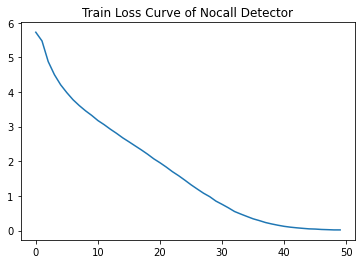

In [17]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Nocall Detector')

Text(0.5, 1.0, 'Validation Accuracy Curve of Nocall Detector')

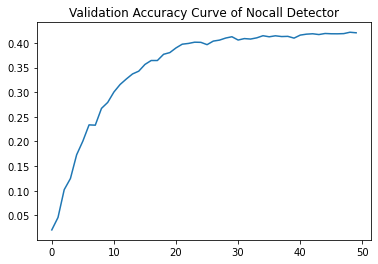

In [18]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Nocall Detector')

Text(0.5, 1.0, 'Log-score Curve of Nocall Detector')

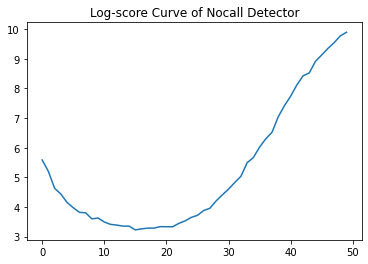

In [19]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Nocall Detector')

Text(0.5, 1.0, 'F-beta score Curve of Nocall Detector')

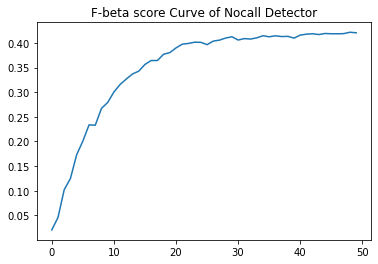

In [20]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Nocall Detector')

In [21]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 41.53
Log Loss score:	9.84
Fbeta-score (beta=1.0): 	0.42
